### `Survey` Tutorial

This tutorial introduces a reader to a `Survey` class: a lightweight wrapper around a SEG-Y file which provides access to its trace headers and means to load various seismic gathers. <br>
The notebook leads through `Survey` initialization and highlights its most useful attributes and methods. <br>

### Table Of Contents

[SEG-Y format](#SEG-Y-format) <br>
[Introduction](#Introduction) <br>
[Attributes](#Attributes) <br>
[Methods](#Methods) <br>
[Creating a gather](#Creating-a-gather) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys

from utils import generate_trace

sys.path.append('..')
from seismicpro import Survey, make_prestack_segy

### SEG-Y format

`Survey` is a concise image of a SEG-Y file, so it is useful to brush up on the file's format first. The scheme below illustrates a structure of a binary file in a SEG-Y format (revision 2):

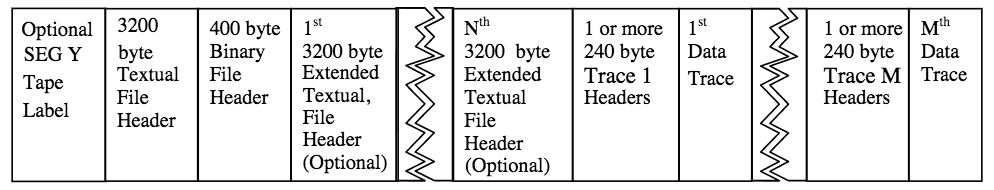

 It consists of three main blocks:<br>
- *File Header* (both textual and binary) with general information about the seismic survey,
- *Trace Headers* with metadata about each trace,
- *Trace Data* with the recorded signal.

`Survey` stores a part of general data from *File Header* and specific fields from *Trace Headers* for each trace. It does not store any *Trace Data*, but can load it and put in generated instances of `Gather` class. This allows keeping memory footprint of a `Survey` to a minimum.

### Introduction

For convenience, this tutorial uses a SEG-Y file with synthetic data that is going to be generated in the following cell:

In [2]:
sgy_path = '/data/synthetic_survey.sgy'
make_prestack_segy(sgy_path, survey_size=(1500, 1500), activation_dist=(1500, 1500), trace_gen=generate_trace)

Common shot gathers generated:   0%|          | 0/150 [00:00<?, ?it/s]

To create a `Survey` object one needs to provide a path to a SEG-Y file and specify trace headers to load:

In [3]:
survey = Survey(sgy_path, header_index='FieldRecord', header_cols='offset')

Trace headers loaded:   0%|          | 0/135000 [00:00<?, ?it/s]

`Survey` object stores loaded trace headers as a `pandas.DataFrame` called `headers`. <br>
`header_index` is a name of a trace header or a list of trace header names that are going to be used as an index of the `headers` `DataFrame`. Its value is also used to group traces into seismic gathers. <br>
`header_cols` can be a string or a list of strings with other trace headers one needs to load for further processing.<br>
All available trace headers are listed in [Trace headers keys](https://segyio.readthedocs.io/en/latest/segyio.html#trace-header-keys) section of `segyio` library documentation.<br>

To see summary about the SEG-Y file, one can call `info()` method of the initialized object: <br>

In [4]:
survey.info()

Survey path:               /data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Number of traces:          135000
Trace length:              1500 samples
Sample interval:           2.0 ms
Sample rate:               500.0 Hz
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]
Is uphole:                 Unknown

Indexed by:                FieldRecord
Number of gathers:         150
Mean gather fold:          900

Source ID headers:         FieldRecord
Number of sources:         150
Mean source fold:          900


In this example `survey` is indexed by `'FieldRecord'` - a header that describes energy sources. Since `Survey` groups traces into gathers by the common value of `header_index`, the created survey will generate common shot gathers. See a table that lists gather types and corresponding values of `header_index` below:

| Gather type | header_index |
| :- | -: |
| Common-shot gather | `'FieldRecord'` |
| Common-midpoint gather | `'CDP'` / `['INLINE_3D', 'CROSSLINE_3D']`|
| Common-receiver gather | `['GroupX', 'GroupY']` |
| Common-offset section | `'offset'` |

### Attributes

Let's look at some useful attributes of the `Survey` class:

<b>`headers`</b> - `pandas.DataFrame` containing loaded headers for each trace in the file. <br>

In [5]:
survey.headers

,TRACE_SEQUENCE_FILE,offset,TRACE_POS_IN_SURVEY
FieldRecord,,,
0,1,0,0
0,2,25,1
0,3,50,2
0,4,75,3
0,5,100,4
...,...,...,...
149,134996,182,134995
149,134997,206,134996
149,134998,230,134997


<b>`indexed_by`</b> - names of trace headers used to group traces into gathers. <br>

In [6]:
survey.indexed_by

'FieldRecord'

<b>`indices`</b> - unique values of headers the survey is indexed by. <br>

In [7]:
survey.indices

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
           dtype='int64', name='FieldRecord', length=150)

<b>`n_gathers`</b> - the number of gathers in the survey, a shortcut for `len(survey.indices)`. The considered SEG-Y file contains 150 common shot gathers. <br>

In [8]:
survey.n_gathers

150

<b>`n_traces`</b> - the number of traces in the survey, a shortcut for `len(survey.headers)`. <br>

In [9]:
survey.n_traces

135000

<b>`sample_interval` </b> - sampling interval of traces in milliseconds.

In [10]:
survey.sample_interval

2.0

<b>`sample_rate` </b> - sampling rate of traces in Hz.

In [11]:
survey.sample_rate

500.0

<b>`samples`</b> or <b>`times`</b> - arrays of recording times of trace samples in milliseconds. Difference between each two adjacent values equals to the `sample_interval`.

In [12]:
survey.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03])

<b>`n_samples`</b> or <b>`n_times`</b> - the number of samples in each trace, a shortcut for `len(survey.samples)`. <br>

In [13]:
survey.n_samples

1500

### Methods

<b>`filter()` </b>

This method returns a new `Survey` object with a subset of original traces that satisfy given condition.

`Survey.filter` expects a condition to be passed as a callable which should accept headers defined by `cols` and return `True` values for traces to be kept in the resulting survey. <br>
This example shows how to select traces with offsets less than 100 meters:

In [14]:
filtered_survey = survey.filter(lambda x: x < 100, cols='offset')
filtered_survey.info()

Survey path:               /data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Number of traces:          1408
Trace length:              1500 samples
Sample interval:           2.0 ms
Sample rate:               500.0 Hz
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 90 m]
Is uphole:                 Unknown

Indexed by:                FieldRecord
Number of gathers:         150
Mean gather fold:          9

Source ID headers:         FieldRecord
Number of sources:         150
Mean source fold:          9


The resulting survey contains less traces than the original one, and their offsets are all less than 100 meters.

<b>`apply()` </b>

Applies a function to values of some `headers` and stores the result as new trace headers.

`Survey.apply` expects a callable and names of columns from `headers` to apply the callable to. <br>
In the example below trace offsets are doubled and the result is stored in a new `'offset_x2'` column. <br>

In [15]:
applied_survey = survey.apply(lambda x: x * 2, cols='offset', res_cols='offset_x2')
applied_survey.headers

,TRACE_SEQUENCE_FILE,offset,TRACE_POS_IN_SURVEY,offset_x2
FieldRecord,,,,
0,1,0,0,0
0,2,25,1,50
0,3,50,2,100
0,4,75,3,150
0,5,100,4,200
...,...,...,...,...
149,134996,182,134995,364
149,134997,206,134996,412
149,134998,230,134997,460


<b>`mark_dead_traces()`</b>

`mark_dead_traces` iterates over all traces in the survey and sets a value of a new `DeadTrace` header to `True` for traces with constant amplitudes. The overall number of dead traces is stored in the `n_dead_traces` attribute.

In [16]:
survey.mark_dead_traces()

Detecting dead traces for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

In [17]:
survey.info()

Survey path:               /data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Number of traces:          135000
Trace length:              1500 samples
Sample interval:           2.0 ms
Sample rate:               500.0 Hz
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]
Is uphole:                 Unknown

Indexed by:                FieldRecord
Number of gathers:         150
Mean gather fold:          900

Source ID headers:         FieldRecord
Number of sources:         150
Mean source fold:          900

Number of dead traces:     0


<b>`collect_stats()`</b>

`collect_stats` is used to calculate statistics of trace amplitudes and store them as `Survey` attributes. If `mark_dead_traces` method hasn't been called, a warning is raised, since dead traces may skew data statistics.

In [18]:
survey.collect_stats()

Calculating statistics for traces in survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

In [19]:
survey.info()

Survey path:               /data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Number of traces:          135000
Trace length:              1500 samples
Sample interval:           2.0 ms
Sample rate:               500.0 Hz
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]
Is uphole:                 Unknown

Indexed by:                FieldRecord
Number of gathers:         150
Mean gather fold:          900

Source ID headers:         FieldRecord
Number of sources:         150
Mean source fold:          900

Survey statistics:
mean | std:                      0.01 | 0.63      
 min | max:                     -8.89 | 6.65      
 q01 | q99:                     -1.59 | 1.90      

Number of dead traces:     0


Now `survey.info()` has a new `Survey statistics` section.

These statistics allow performing normalization and standardization of the data, which is quite useful for many Machine Learning tasks.<br>

In case one trains a model not on the whole traces, but on the amplitudes in a specific time window, normalization/standardization should be carried out using statistics calculated in that exact window.<br>
`Survey` provides this option via `limits` parameter of `collect_stats()` method:
```python
survey_with_limits = survey.collect_stats(limits=(0, 1000))
```
Note, that limits are defined in samples, not milliseconds.

### Creating a gather

`Survey` objects do not store seismic data, but they have two methods that allow one to load it into `Gather` objects: `sample_gather` and `get_gather`.

<b>`get_gather()`</b>

`get_gather` expects an index of a gather from `survey.indices` and returns a `Gather` instance with all traces corresponding to the provided index value:<br>
```python
gather = survey.get_gather(some_index)
```

<b>`sample_gather()`</b>

`sample_gather` does the same, but selects a gather index randomly. <br>

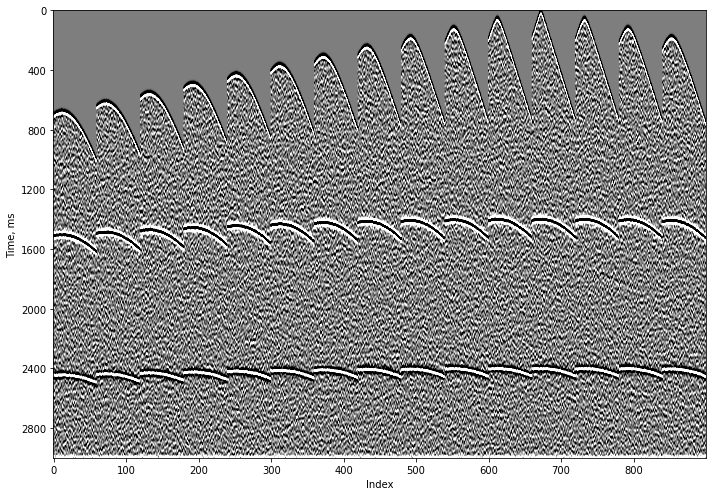

In [20]:
gather = survey.sample_gather()
gather.plot()

Read more about `Gather` in [this tutorial](./2_Gather.ipynb).

### Conclusion

This tutorial
* explained the purpose of the `Survey` class and showed a process of its instantiation,
* described `Survey`'s principal attributes with examples of their contents,
* listed `Survey`'s most important methods with illustrations of their calls.

[Go to top](#Survey-Tutorial)